In [301]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
sns.set()
from results import load

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

#constants
experiment_phase = {'p0':60000, 'p1':60000, 'p2':180000}
experiment_phase_labels = [*experiment_phase]

# Reading the results

In [370]:
#config
experiment_name = "full"
load_raw = False
all = None
providers = None
num_repetitions = None
configs = None

if load_raw:

    providers = ["aws","azure","ibm","gcf"] 
    num_repetitions = 1
    configs = ["0,0,1", "0,0,2","0,0,0.5","60,60,1","60,60,0.5"]


    all = load(experiment_name, providers,configs,num_repetitions,True)
    all.to_csv("results/full.csv")
else :
    all = pd.read_csv("results/full.csv")#
    providers = all["Provider"].unique()
    num_repetitions = all["run"].max()
    configs = all["WL"].unique()

all.columns


Index(['Unnamed: 0', 'RId', 'WL', 'CId', 'CStart', 'ECost', 'DLat', 'ELat',
       'RFailed', 'Phase', 'RStart', 'EStart', 'EEnd', 'REnd', 'CNew', 'CPlat',
       'TLat', 'COs', 'RInput', 'Provider', 'RLat', 'BLat', 'RResult', 'run',
       'sourceFile', 'RCode', 'RSuccessed', 'HId'],
      dtype='object')

In [368]:
def plotWorkload(ax,data,label="Target Workload",interval=1000):
    data["RStart_1s"] = round(data["RStart"]/interval)
    lats = data.groupby(["RStart_1s"])['RId'].count().reset_index(name="workload")
    sns.lineplot(x="RStart_1s", y='workload', data=lats, color="gray",label=label,ax=ax)
    
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import colorsys
    h = color.lstrip('#')
    
    c = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    c = map(lambda x:min(x+10,255),c)
    c = map(lambda x:hex(x)[2:],c)
    return "#{}{}{}".format(*c)

#4c72b0


(38.5, 57.49999999999997, 88.5, 1.0)

In [362]:
#sns.set_palette(sns.color_palette("Paired"))

palette = sns.color_palette().as_hex()
style = {
    "aws":{
        "name":"AWS",
        "color":palette[0]
    },
    "ibm":{
        "name":"ICF",
        "color":palette[1]
    },
    "gcf":{
        "name":"GCF",
        "color":palette[2]
    },
    "azure":{
        "name":"MAF",
        "color":palette[4]
    },
}


In [395]:
all = all[(all["Phase"] != "none")]

all[all["HId"].notna()]["HId"] = all[all["HId"].notna()]["HId"][:-1]

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Cost per Request

In [306]:
def costPerSecond(ax,all,provider,workload):
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    #plot
    sns.violinplot(x='Phase', y='ECost', data=data,  inner='quartile')
    #ax.scatter(x="EStart_1s",y="ECost",data=data,label=provider,color=style[provider]["color"],alpha=0.8)


    # ax.set_xlim([0,300])
    ax.set_xlabel("Phases")
    ax.set_ylabel(r"cost [$\mu$\$]")
    ax.set_ylim([0,1000])
    ax.grid(False)
    #title
    ax.set_title("{} - Cost per Request".format(style[provider]["name"]))
#     data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
#     data = data.copy()
    
#     #goup by second
#     data["EStart_1s"] = round(data["EStart"]/1000)
#     #sum up cost
#     data = data.groupby(["EStart_1s","Phase"])["ECost"].sum().reset_index(name="ECost")
#     #plot
    
#     ax.scatter(x="EStart_1s",y="ECost",data=data,label=provider,color=style[provider]["color"],alpha=0.8)
   
    
#     ax.set_xlim([0,300])
#     ax.set_xlabel("time [s]")
#     ax.set_ylabel(r"cost [$\mu$\$]")
    
#     #highlight phases
#     ax.axvline(60,alpha=0.5)
#     ax.axvline(120,alpha=0.5)
#     ax.grid(False)
#     ax.set_xticks(ticks=[30,90,210])
#     ax.set_xticks(ticks=range(0,300,20),minor=True)
#     ax.set_xticklabels(["p0","p1","p2"])
#     ax.set_xticklabels(range(0,300,20),minor=True)
#     ax.tick_params(axis='both', which='major', pad=15)
#     #title
#     ax.set_title("{} - Cost per Second".format(style[provider]["name"]))
    
#     #legend
#     ax.legend()

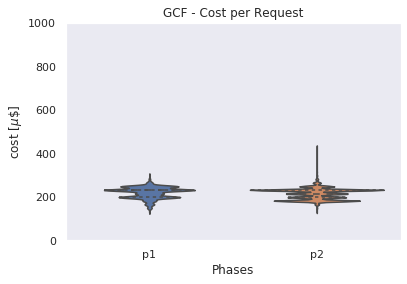

In [307]:

fig,ax = plt.subplots()
costPerSecond(ax,all,"gcf","0,0,2")




### VM Usage

In [389]:
provider = "gcf"
workload = "60,60,0.5"
def plotHeatmap(ax,all,provider,workload,selector="HId",cutoff=0.5):
    #filter data
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    data = data[["EStart","EEnd",selector,"RId"]].copy()
    #remove NAN
    data = data[data["EStart"].notna()]
    data = data.reset_index()
    #second buckets
    data["EStart"] = (data["EStart"]//1000)
    data["EEnd"] = (data["EEnd"]//1000)

    #remove lower 20%
    X = data.groupby(selector)["RId"].count().reset_index(name="c")
    X = X[X["c"] > X["c"].quantile(cutoff)]

    HIdIndex = {}
    idx = 0
    for hid in X[selector].unique():
        HIdIndex[hid] = idx
        idx+=1

    heatmap = np.zeros((len(HIdIndex),150))
    for i in range(1,len(data)):
        x = data.loc[i,[selector,"EStart","EEnd"]]
        if x[selector] in HIdIndex.keys():
            for j in np.arange(x["EStart"],min(300,x["EEnd"]),2):
                heatmap[HIdIndex[x[selector]],int(j//2)] +=1


    sns.heatmap(heatmap,ax=ax,cmap=sns.cubehelix_palette(8),linewidths=0,cbar=False)

    ax_divider = make_axes_locatable(ax)
    # define size and padding of axes for colorbar
    cax = ax_divider.append_axes('right', size = '2.5%', pad = '1%')
    # make colorbar for heatmap. 
    # Heatmap returns an axes obj but you need to get a mappable obj (get_children)
    colorbar(ax.get_children()[0], cax = cax, orientation = 'vertical')
    # locate colorbar ticks
    cax.xaxis.set_ticks_position('top')
    ax.set_yticklabels([""])
    ax.set_xticks(ticks=[15,45,115])
    ax.set_xticks(ticks=range(0,150,15),minor=True)
    ax.set_xticklabels(["p0","p1","p2"],rotation='horizontal')
    ax.set_xticklabels(range(0,300,30),minor=True)
    ax.tick_params(axis='x', which='major', pad=15)
    ax.set_title("{} - Requests per VM".format(style[provider]["name"]))
    ax.set_ylabel("VMs")
    ax.set_xlabel("time [s]")


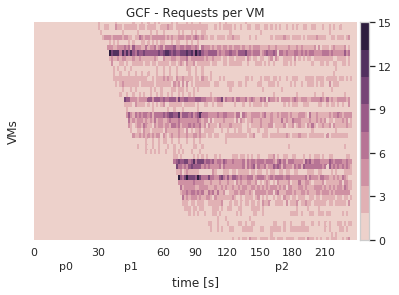

In [399]:
fig,ax = plt.subplots()
plotHeatmap(ax,all,"gcf","0,0,1",selector="HId",cutoff=0.25)

## Failed Request

In [310]:
def plotFailedRequestPerSecond(ax,all,provider,workload,plot_target=True,label=None):
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    data = data.copy()
    if plot_target:
        plotWorkload(ax,data)
        
    data["RStart_1s"] = round(data["RStart"]/1000)
    #sum up cost
    data = data.groupby(["RStart_1s"])["RFailed"].sum().reset_index(name="RFailed")
    if label == None:
        label = "{}".format(style[provider]["name"])
    
    data = data[data["RFailed"] > 0]
    ax.scatter(x="RStart_1s", marker="+",y='RFailed', data=data, color="indianred",label=label,s=40)
    ax.set_xlim([0,300])
    ax.set_xlabel("time [s]")
    ax.set_ylabel(r"failed requests [#]")

    #highlight phases
    ax.axvline(60,alpha=0.7,color="black")
    ax.axvline(120,alpha=0.7,color="black")
    for i in range(0,300,20):
        ax.axvline(i,alpha=0.2,color="black")
    
    ax.grid(False)
    ax.set_xticks(ticks=[30,90,210])
    ax.set_xticks(ticks=range(0,300,20),minor=True)
    ax.set_xticklabels(["p0","p1","p2"])
    ax.set_xticklabels(range(0,300,20),minor=True)
    ax.tick_params(axis='both', which='major', pad=15)

    #title
    ax.set_title("{} - Failed Request per Second".format(style[provider]["name"]))

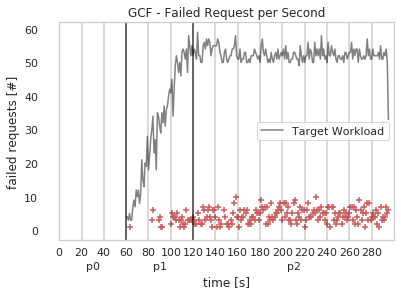

In [396]:
fig,ax = plt.subplots()
plotFailedRequestPerSecond(ax,all,"gcf","0,0,1")

### Throughput

In [347]:
def thruputPerSecond(ax,all,provider,workload,filter_failed=False,with_failed=True):
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    data = data.copy()
    
    if with_failed:
        plotFailedRequestPerSecond(ax,data,provider,workload,False,
                                   "Failed Requests")
    
    if filter_failed:
        data = data[data["RFailed"] == False]
        
    data["REnd_1s"] = round(data["REnd"]/1000)
    plotWorkload(ax,data)
    #goup by second
    data = data.groupby(["REnd_1s","CNew"])["RId"].count().reset_index(name="throughput")
    #plot
    ax.scatter(x="REnd_1s",y="throughput",marker="o",data=data[data["CNew"] == "Reused"],
               label="Throughput (Warm)",c=style[provider]["color"],s=12)
    ax.scatter(x="REnd_1s",y="throughput",marker="s",data=data[data["CNew"] == "New"],
               label="Throughput (Cold)",c=lighten_color(style[provider]["color"],0.8),
               alpha=0.8,s=12)
    
    ax.set_xlim([0,300])
    ax.set_xlabel("time [s]")
    ax.set_ylabel(r"request [#]")
    ax.set_ylim([0,180])
    
    #highlight phases
    ax.axvline(60,alpha=0.7,color="black")
    ax.axvline(120,alpha=0.7,color="black")
    for i in range(0,300,20):
        ax.axvline(i,alpha=0.1,color="black")
    
    ax.grid(False)
    ax.set_xticks(ticks=[30,90,210])
    ax.set_xticks(ticks=range(0,300,20),minor=True)
    ax.set_xticklabels(["p0","p1","p2"])
    ax.set_xticklabels(range(0,300,20),minor=True)
    ax.tick_params(axis='both', which='major', pad=15)

    #title
    ax.set_title("{} - Throughput per Second".format(style[provider]["name"]))

    #legend
    ax.legend()


#8172b3


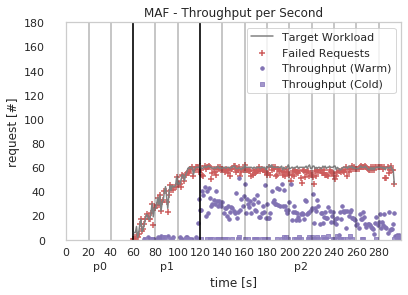

In [366]:
fig,ax = plt.subplots()
thruputPerSecond(ax,all,"azure","0,0,1",False)

## Request Latency

In [314]:
def plotRequestResponseViolin(ax,all,provider,workload):
    ax.set_title("{} Request Response Latency ".format(style[provider]["name"]))
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    data = data[data["RLat"].notna()]
    data = data[data["RCode"] != 429] #filters filed requests e.g. azure
    #data = data[data["Phase"].isin(["p1","p2"])]
    inner = None
    sns.violinplot(x='Phase', y='RLat', data=data,  scale='area',cut=0,ax=ax,  inner='quartile')
    
    #ax.set_yscale('log')

    ax.set_xlabel("Phases")
    ax.set_ylabel(r"Request Response Latency [s]")
    ax.set_ylim([0,30])
    #highlight phases

    #ax.set_xticklabels(["p0","p1","p2","none"])

    delta = 0.02
    delta = 0.02

    #code for gap between violin halves, from stackoverflow.com/questions/43357274/
    for ii, item in enumerate(ax.collections):
    # axis contains PolyCollections and PathCollections
        if isinstance(item, matplotlib.collections.PolyCollection):
        # get path
            path, = item.get_paths()
            vertices = path.vertices

        # shift x-coordinates of path
            if not inner:
                if ii % 2: # -> to right
                    vertices[:,0] += delta
                else: # -> to left
                    vertices[:,0] -= delta
            else: # inner='box' adds another type of PollyCollection
                if ii % 3 == 0:
                    vertices[:,0] -= delta
                elif ii % 3 == 1:
                    vertices[:,0] += delta
                else: # ii % 3 = 2
                    pass

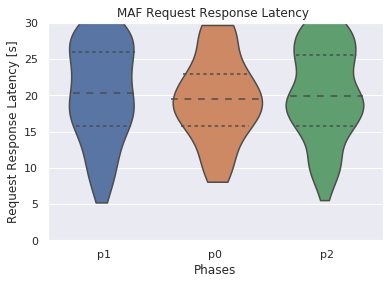

In [315]:
fig,ax = plt.subplots()

plotRequestResponseViolin(ax,all,"azure","60,60,1")

## Merged Latancy Plot

In [320]:
def plotLatencyViolin(ax,all,provider,workload):
    ax.set_title("{} Execution Latency ".format(style[provider]["name"]))
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    data = data[data["ELat"].notna()]
    data = data[data["RCode"] != 429] #filters filed requests e.g. azure
    #data = data[data["Phase"].isin(["p1","p2"])]
    #This is mindfuck, lets not talk about it!
    data = data[["RLat","ELat","Phase"]].melt(["Phase"])
    data = data.replace({'variable': "ELat"}, {'variable': 'Execution'})
    data = data.replace({'variable': "RLat"}, {'variable': 'Request Response'})
    data = data.rename(columns={"variable": "Latencies"})
    sns.violinplot(x='Phase', y='value',hue="Latencies", data=data,  scale='area',
                   cut=0,ax=ax,  inner='quartile',split=True)

    #ax.set_yscale('log')

    ax.set_xlabel("Phases")
    ax.set_ylabel(r"Latency [s]")
    ax.set_ylim([0,20])
    #highlight phases

    #ax.set_xticklabels(["p0","p1","p2","none"])

    delta = 0.02
    delta = 0.02

    #code for gap between violin halves, from stackoverflow.com/questions/43357274/
    for ii, item in enumerate(ax.collections):
    # axis contains PolyCollections and PathCollections
        if isinstance(item, matplotlib.collections.PolyCollection):
        # get path
            path, = item.get_paths()
            vertices = path.vertices

        # shift x-coordinates of path
            if not inner:
                if ii % 2: # -> to right
                    vertices[:,0] += delta
                else: # -> to left
                    vertices[:,0] -= delta
            else: # inner='box' adds another type of PollyCollection
                if ii % 3 == 0:
                    vertices[:,0] -= delta
                elif ii % 3 == 1:
                    vertices[:,0] += delta
                else: # ii % 3 = 2
                    pass

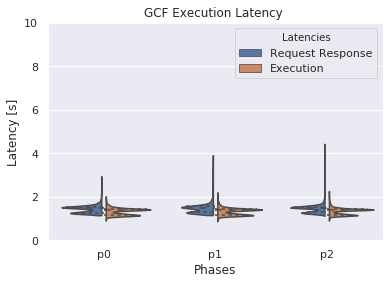

In [317]:
fig,ax = plt.subplots()

plotLatencyViolin(ax,all,"gcf","60,60,1")

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


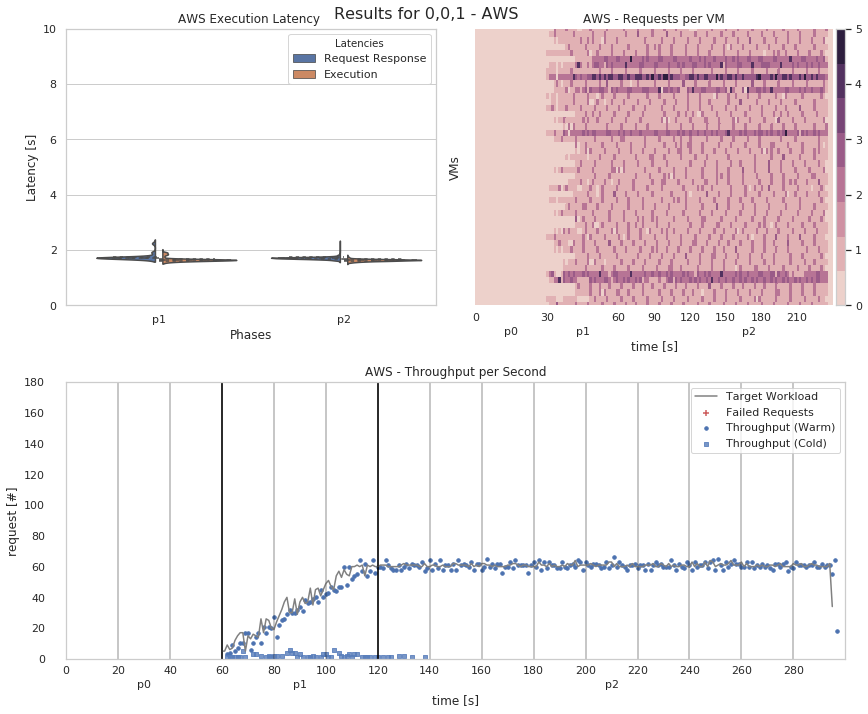

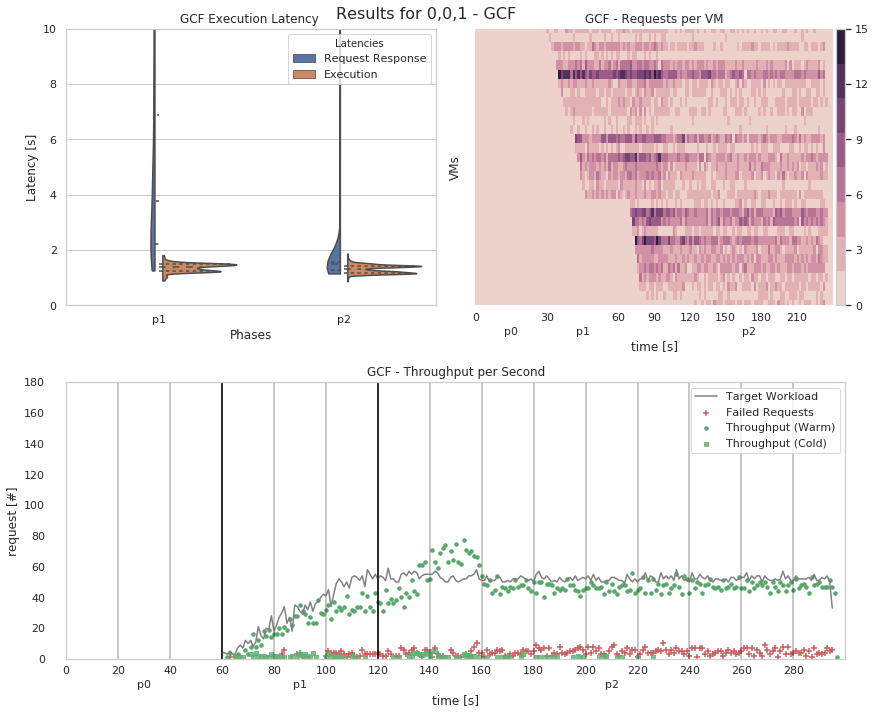

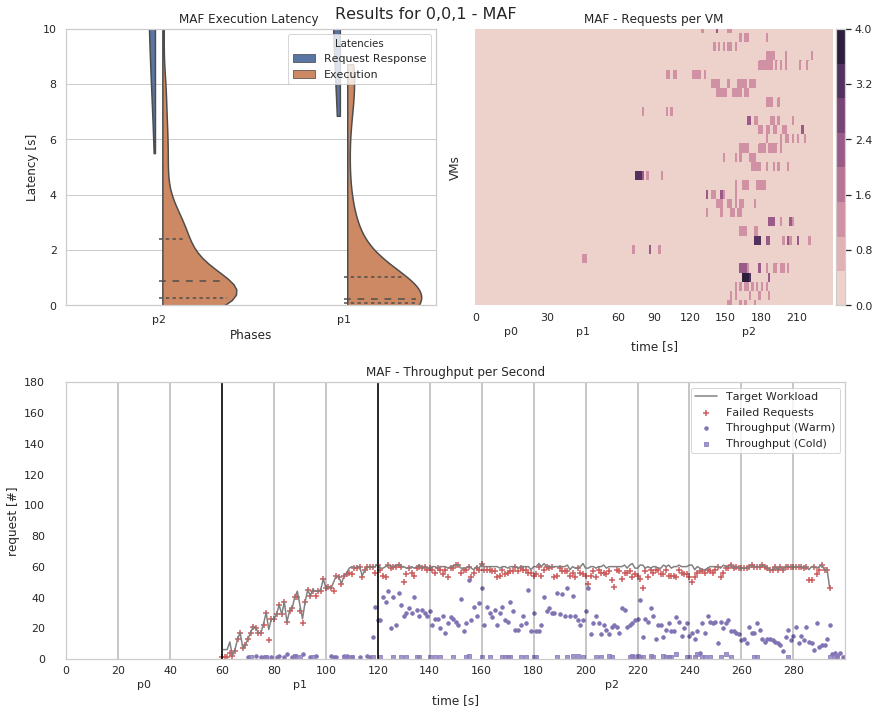

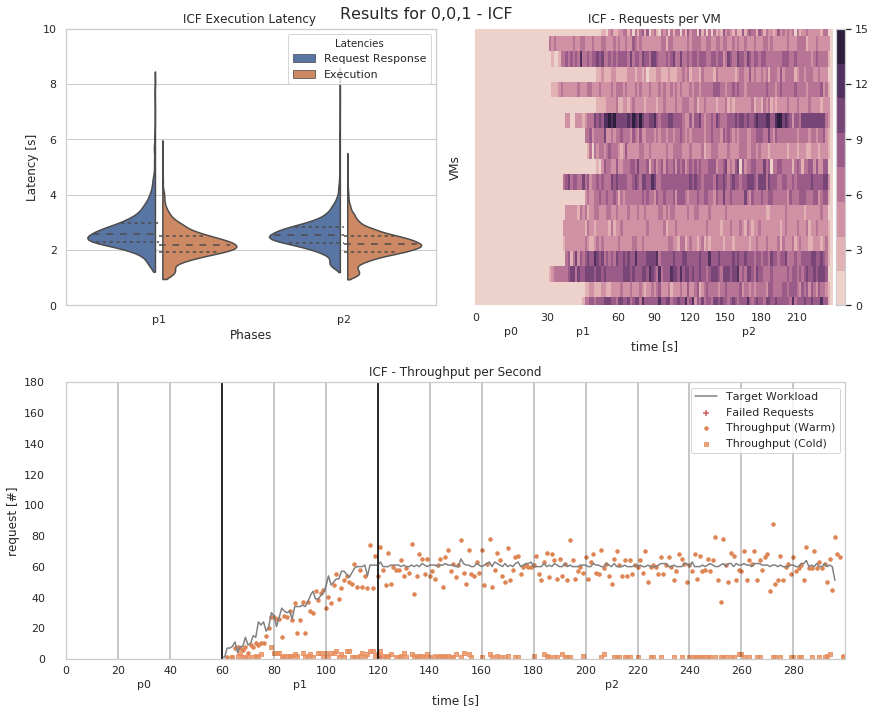

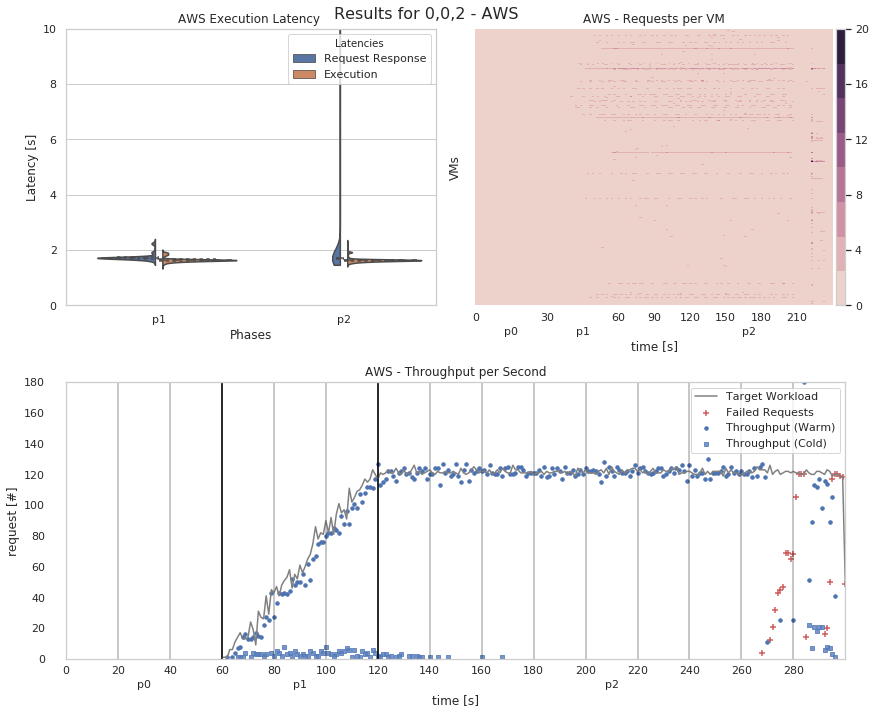

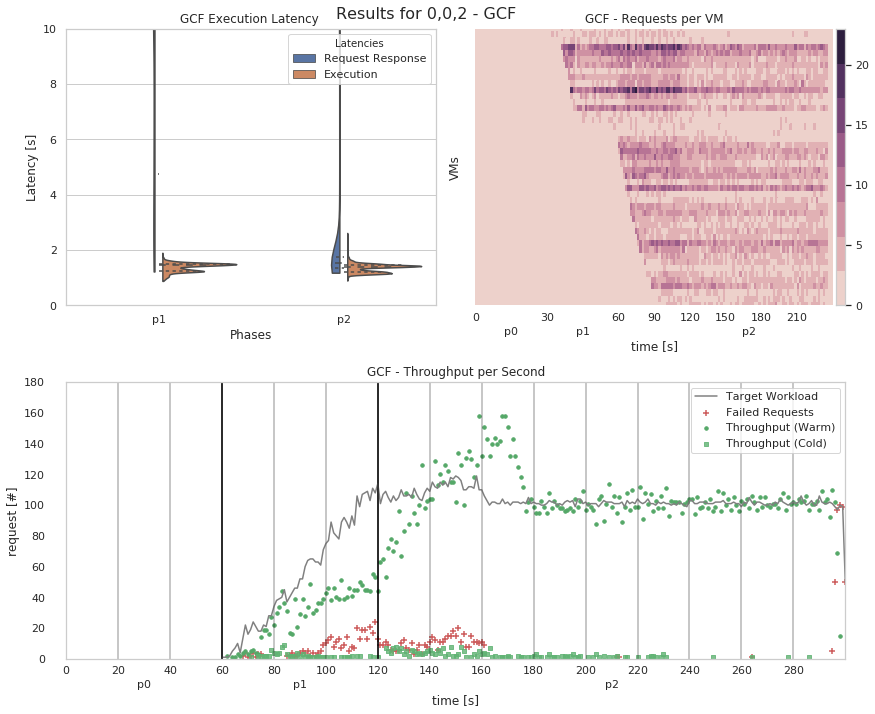

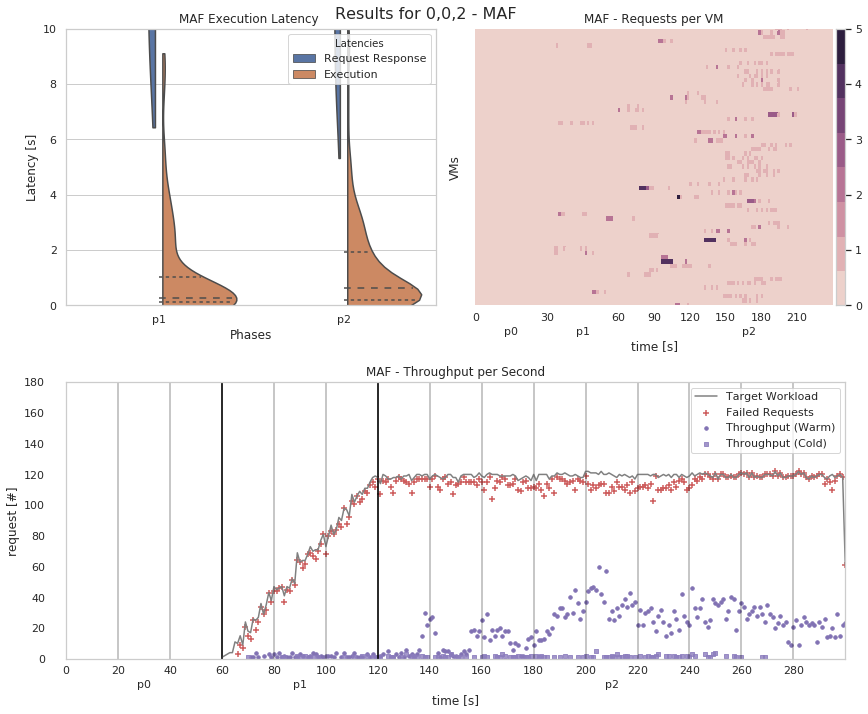

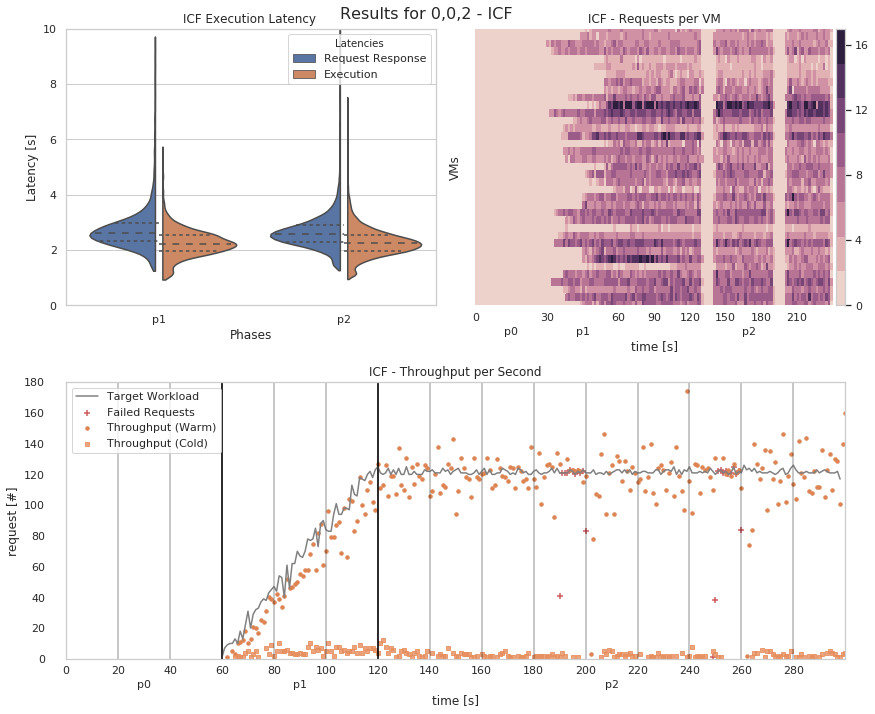

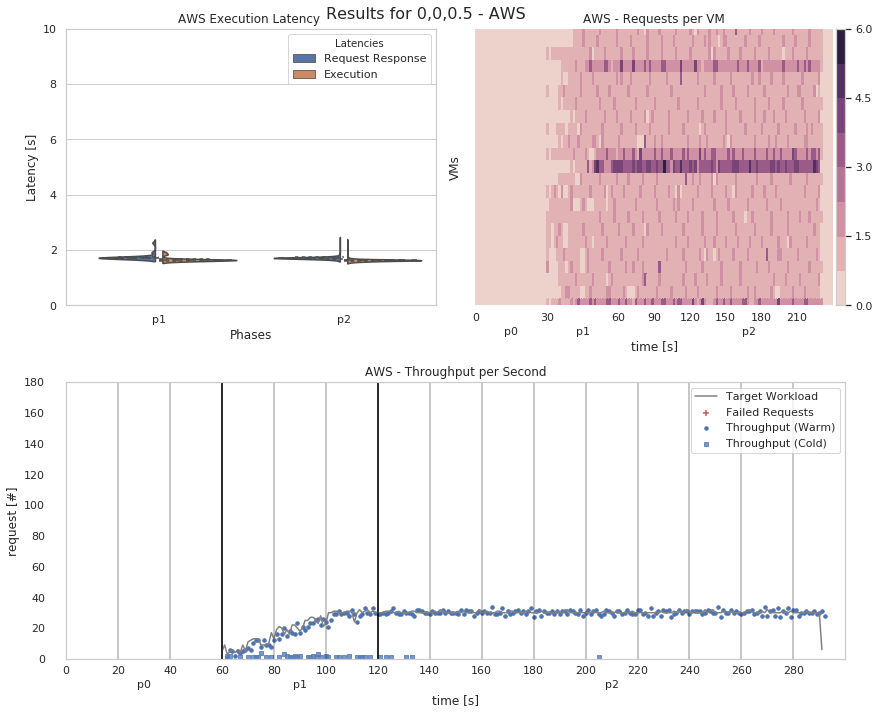

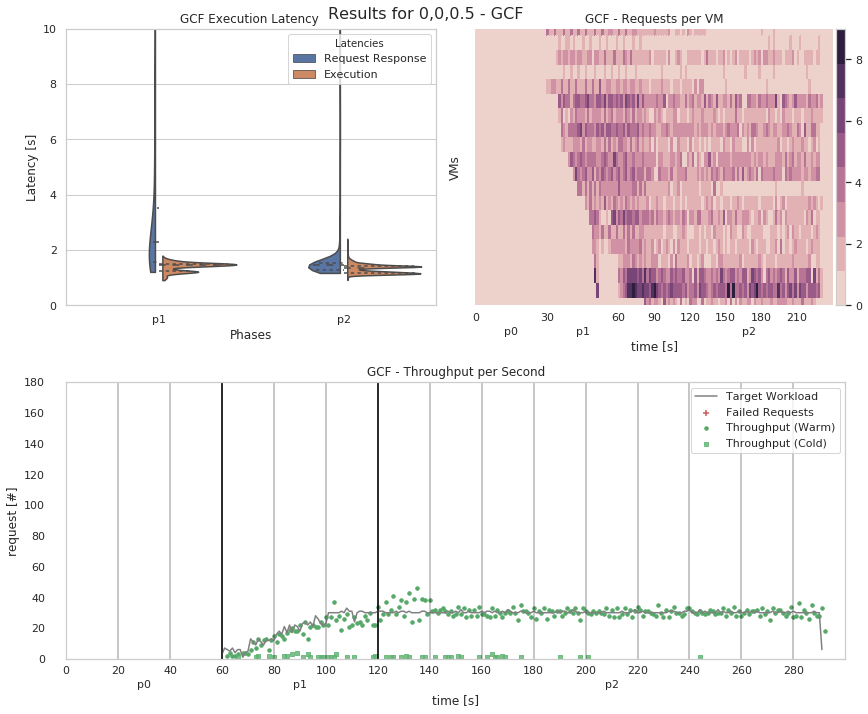

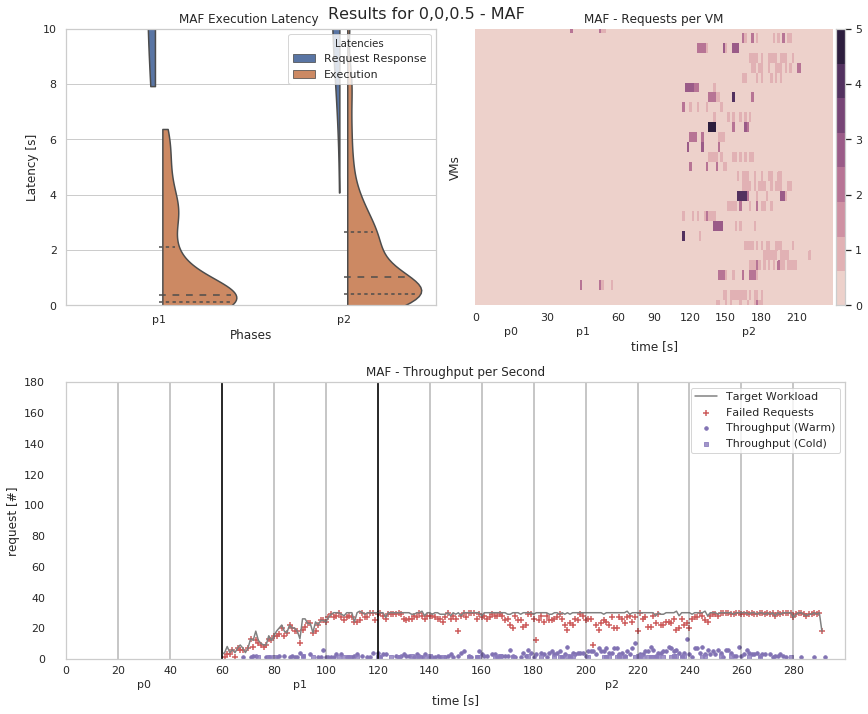

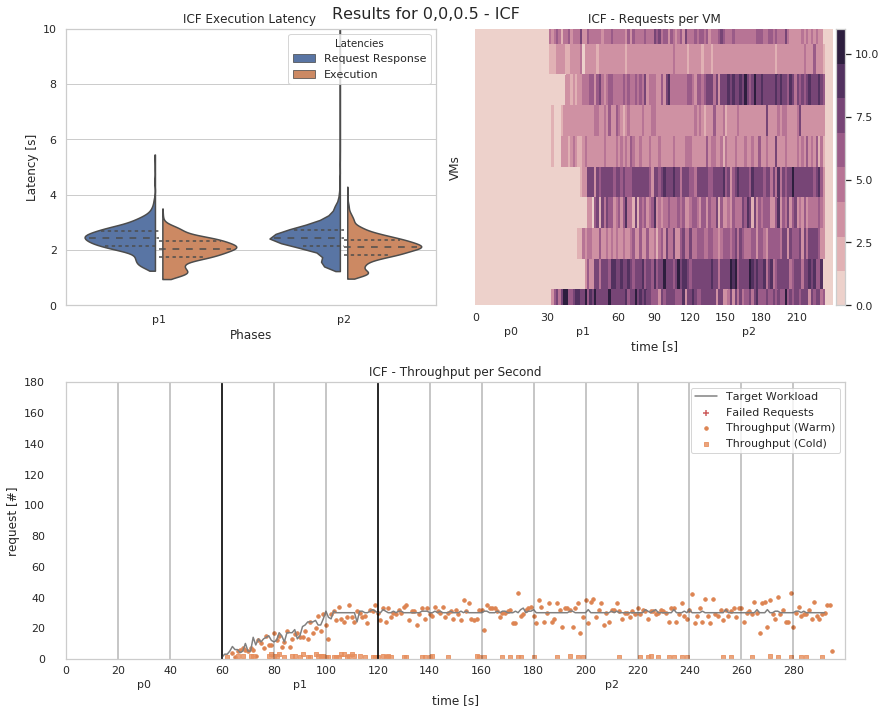

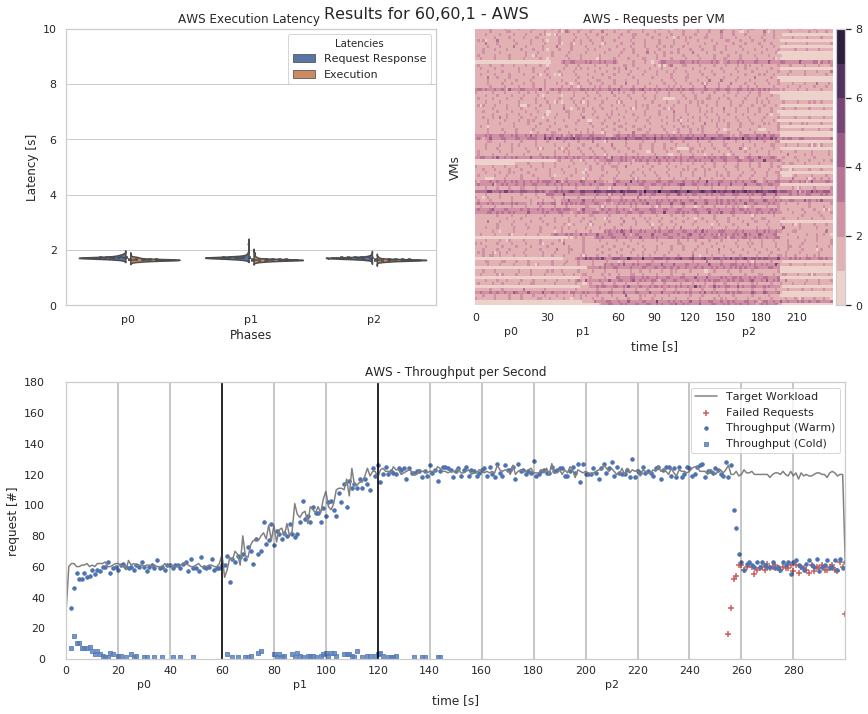

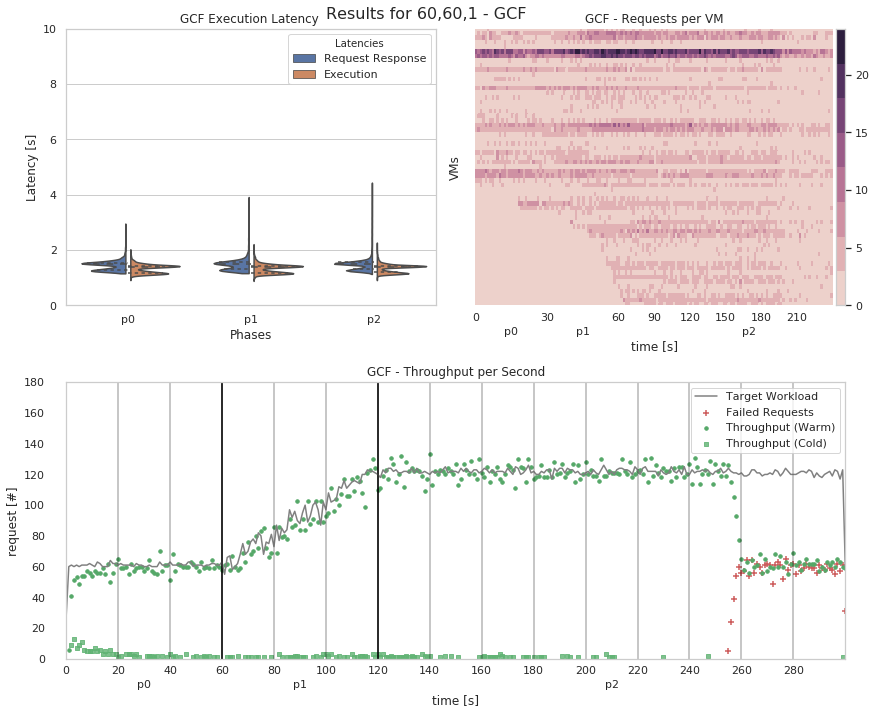

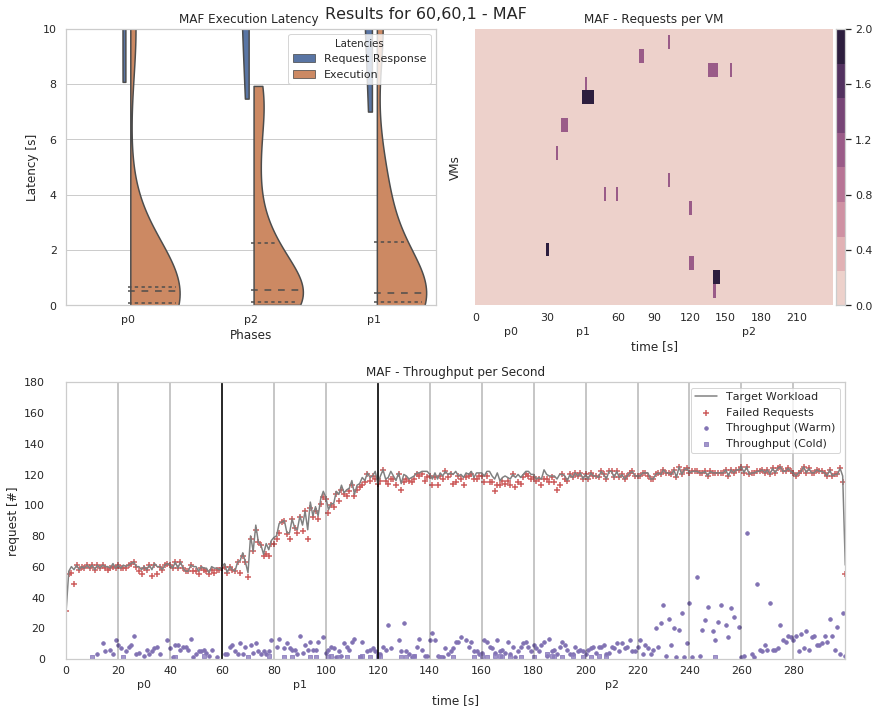

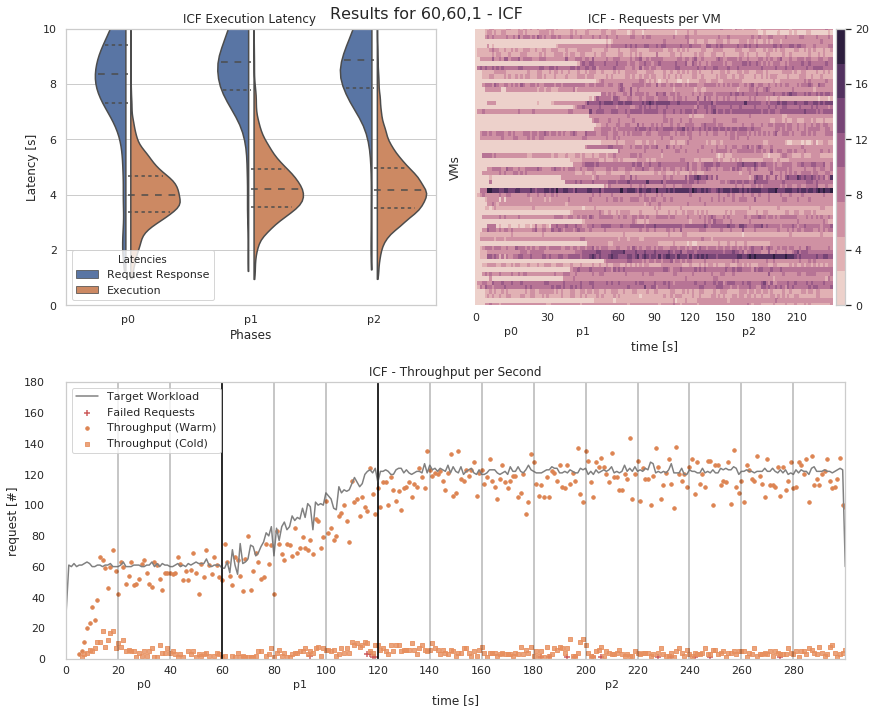

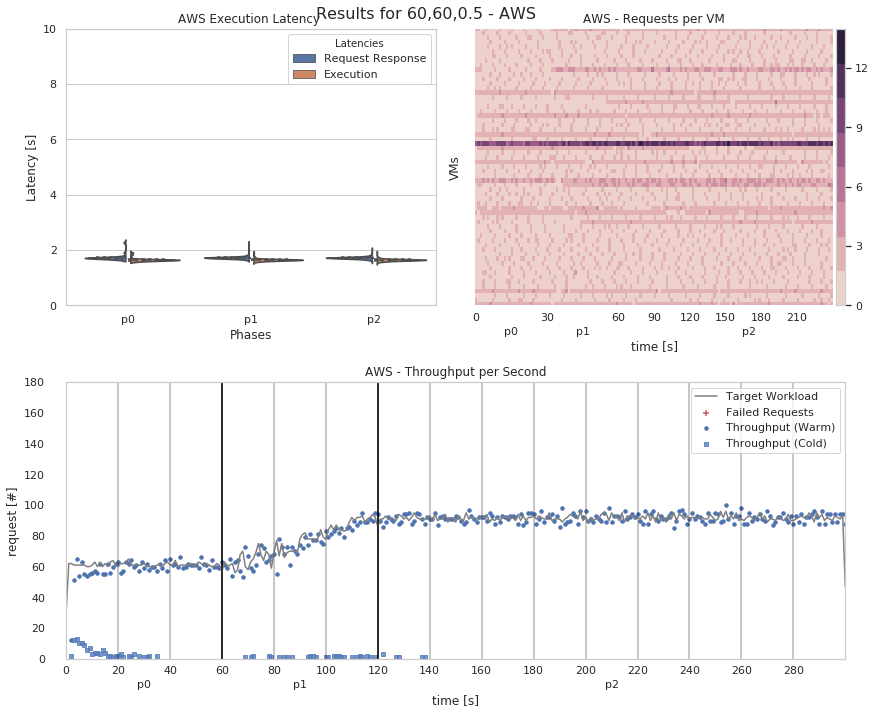

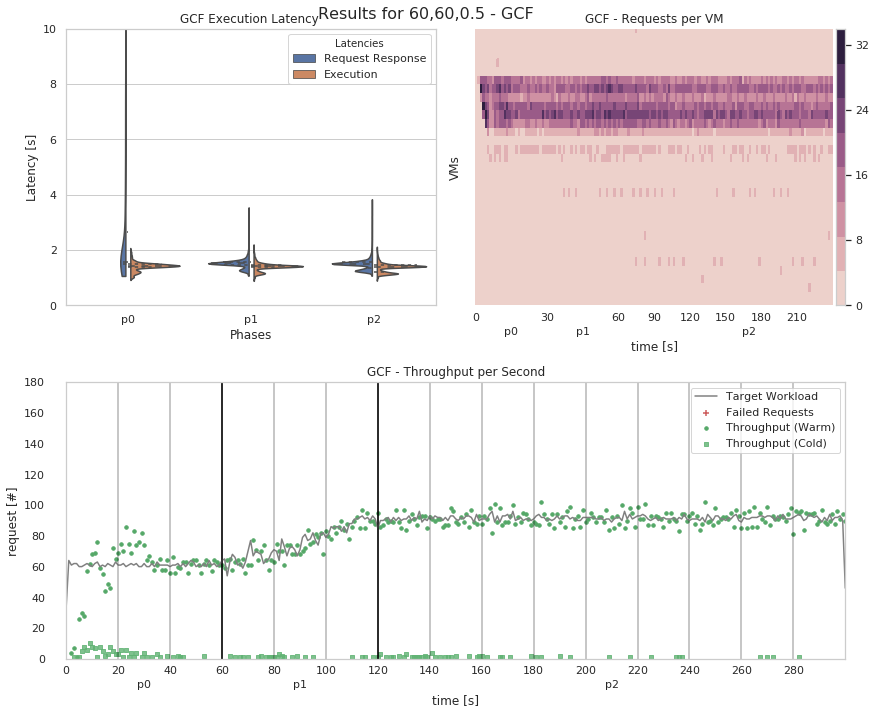

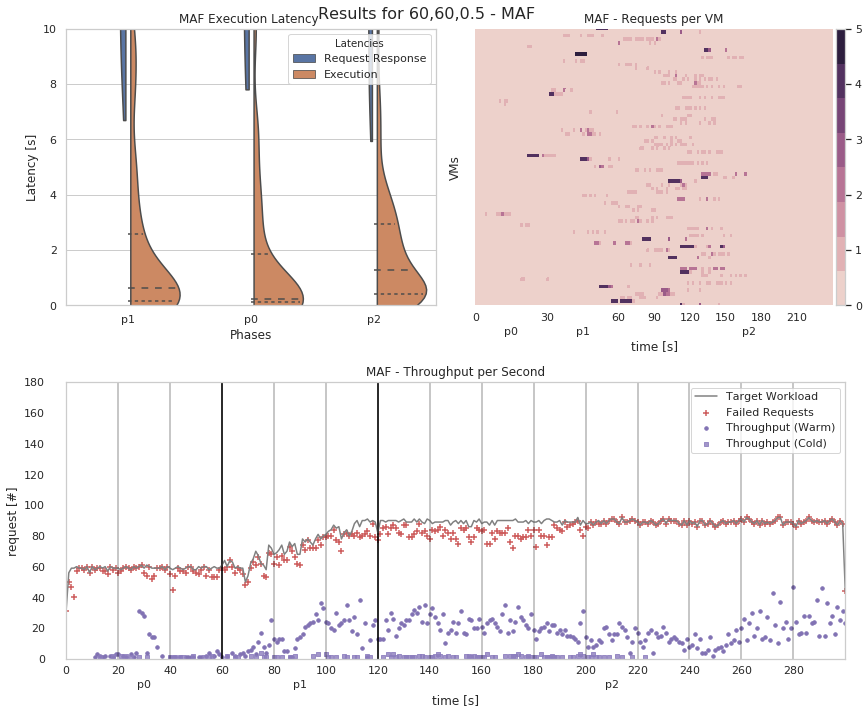

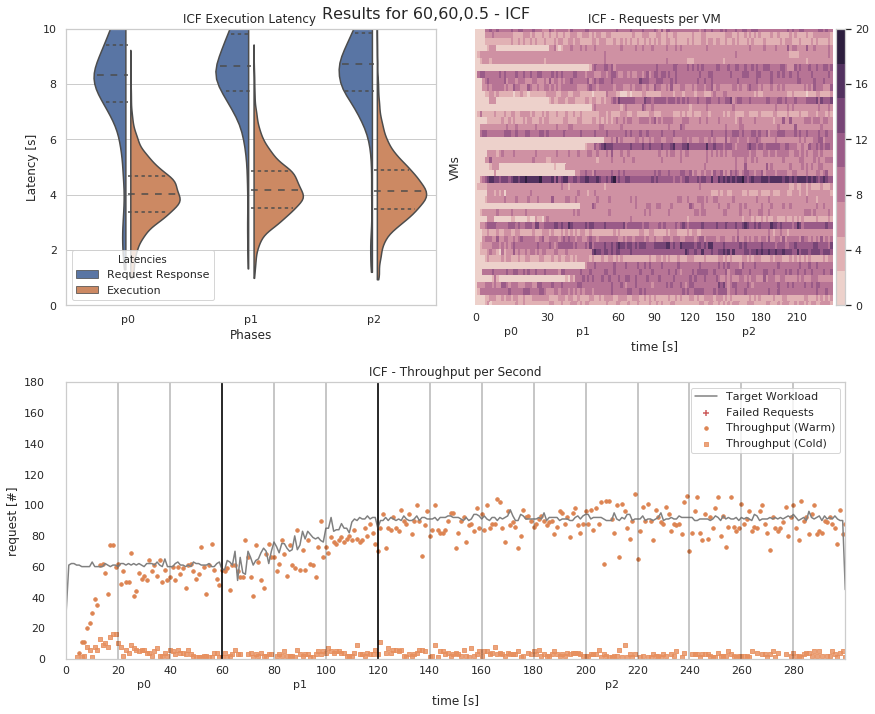

In [391]:
sns.set(style="whitegrid")
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
with PdfPages("reports/overview.pdf") as pdf:
    for workload in configs:
        for provider in providers:
            fig = plt.figure(figsize=(12,10))
            gs = GridSpec(2, 2, figure=fig)
            plt.suptitle("Results for {} - {}".format(workload,style[provider]["name"]), fontsize=16,y=0.99)
            ax = fig.add_subplot(gs[0, 0])
            plotLatencyViolin(ax,all,provider,workload)
            ax = fig.add_subplot(gs[0, 1])
            plotHeatmap(ax,all,provider,workload)
            ax = fig.add_subplot(gs[1, :])
            thruputPerSecond(ax,all,provider,workload)
            #ax = fig.add_subplot(gs[1, 1])
            #costPerSecond(ax,all,provider,workload)
            plt.tight_layout()
            pdf.savefig(fig)
